# 필요한 라이브러리 로드

In [1]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy
# 시각화를 위한 seaborn, matplotlib.pyplot 을 로드한다
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 구버전 주피터 노트북의 경우 시각화 표시 안되는 경우도 있음
%matplotlib inline

# 데이터셋 로드

In [2]:
df = pd.read_csv('data/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.shape

(768, 9)

## 데이터셋 구성
- Pregnancies : 임신 횟수
- Glucose : 2시간 동안의 경구 포도당 내성 검사에서 혈장 포도당 농도
- BloodPressure : 이완기 혈압(mm Hg)
- SkinThickness : 삼두근 피부 주름 두께(mm), 체지방을 추정하는데 사용되는 값
- Insulin : 2시간 혈청 인슐린 (mu U /ml)
- BMI : 체질량 지수 (체중kg / 키(m)^2)
- DiabetesPedigreeFunction : 당뇨병 혈통 기능
- Age : 나이
- Outcome : 700개 중에 268개의 결과 클래스 변수(0 또는 1)는 1이고 나머지는 0

# 학습, 예측 데이터셋 나누기

In [4]:
# label 값을 기준으로 나눈다
# 나누기 전에 label 값을 시각화
(df["Insulin"]>0).value_counts()

True     394
False    374
Name: Insulin, dtype: int64

In [5]:
# train 세트를 만든다
train = df[df["Insulin"]>0].copy()
train.shape

(394, 9)

In [6]:
test = df[df["Insulin"]==0].copy()
test.shape

(374, 9)

# EDA

F:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Insulin', ylabel='Density'>

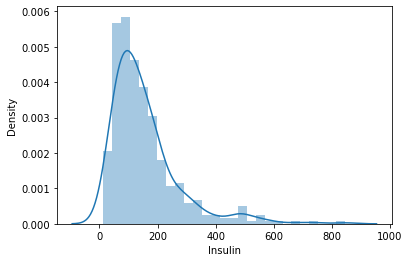

In [7]:
sns.distplot(train["Insulin"])

F:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Insulin'>

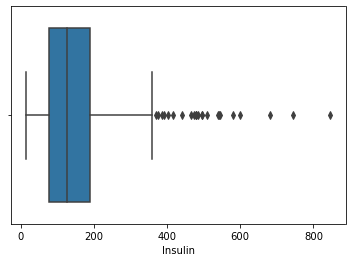

In [8]:
sns.boxplot(train["Insulin"])

- IQR 값의 1.5배를 넘어가는 값을 이상치로 잡는다

In [9]:
desc = train["Insulin"].describe()
desc

count    394.000000
mean     155.548223
std      118.775855
min       14.000000
25%       76.250000
50%      125.000000
75%      190.000000
max      846.000000
Name: Insulin, dtype: float64

In [10]:
# IQR : 3IQR- 1IQR 
# OUT(이상치) =  3IQR + (IQR * 1.5)
IQR = desc.loc["75%"] - desc.loc["25%"]
OUT = desc.loc["75%"] + (IQR * 1.5)

In [11]:
train[train["Insulin"]>OUT].shape

(24, 9)

In [12]:
print(train.shape)

(394, 9)


In [13]:
train = train[train["Insulin"]<OUT]
train.shape

(370, 9)

# 학습, 예측에 사용할 컬럼

In [15]:
# feature_names 라는 변수에 학습과 예측에 사용할 컬럼명을 가져온다

feature_names = test.columns.tolist()
feature_names.remove("Insulin")
feature_names

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

# 정답값이자 예측해야 될 값

In [16]:
# label_name 이라는 변수에 예측할 컬럼의 이름을 담는다
label_name = "Insulin"
label_name

'Insulin'

# 학습, 예측 데이터셋 만들기

In [17]:
# 학습 세트 만들기 예) 시험의 기출문제

X_train = train[feature_names]
X_train.shape

(370, 8)

In [18]:
# 정답 값을 만들어준다 예) 기출문제의 정답
y_train = train[label_name]
y_train.shape

(370,)

In [19]:
# 예측에 사용할 데이터세트를 만든다 예) 실전 시험 문제
X_test = test[feature_names]
X_test.shape

(374, 8)

In [20]:
# 예측의 정답값 예) 실전 시험 문제의 정답
y_test = test[label_name]
y_test.shape

(374,)

# 머신러닝 알고리즘 가져오기

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

estimators = [DecisionTreeRegressor(random_state= 42),
         RandomForestRegressor(random_state = 42),
         GradientBoostingRegressor(random_state= 42)]

estimators

[DecisionTreeRegressor(random_state=42),
 RandomForestRegressor(random_state=42),
 GradientBoostingRegressor(random_state=42)]

In [38]:
results = []

for estimator in estimators:
    result = []
    result.append(estimator.__class__.__name__)
    results.append(result)
    
pd.DataFrame(results)

,0
0,DecisionTreeRegressor
1,RandomForestRegressor
2,GradientBoostingRegressor


In [92]:
from sklearn.model_selection import RandomizedSearchCV

results = []

for estimator in estimators:
    result = []

    max_depth = np.random.randint(10, 30, 12)
    max_features = np.random.uniform(0.5, 1.0, 12)

    param_distributions = {"max_depth": max_depth,  "max_features" : max_features}

    regressor = RandomizedSearchCV(estimator,
        param_distributions,
        n_iter=100, # n_iter 의 값을 1000, 10000으로 하면 더 좋은 결과 나올 수 있음
        scoring=None,
        n_jobs=-1,
        cv=5,
        verbose=2,
        random_state = 42)

    regressor.fit(X_train, y_train)
    
    result.append(estimator.__class__.__name__)
    result.append(regressor.best_params_)
    result.append(regressor.best_estimator_)
    result.append(regressor.best_score_)
    result.append(regressor.cv_results_)
    results.append(result)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [93]:
df_cv = pd.DataFrame(results)
df_cv.columns = ["model","params","estimator","r2_score","cv_result"]
df_cv

,model,params,estimator,r2_score,cv_result
0,DecisionTreeRegressor,"{'max_features': 0.9985755398214815, 'max_dept...","DecisionTreeRegressor(max_depth=15, max_featur...",-0.068161,"{'mean_fit_time': [0.011618232727050782, 0.015..."
1,RandomForestRegressor,"{'max_features': 0.5622160692563495, 'max_dept...","(DecisionTreeRegressor(max_depth=14, max_featu...",0.340609,"{'mean_fit_time': [0.566664171218872, 0.598599..."
2,GradientBoostingRegressor,"{'max_features': 0.6250948077742697, 'max_dept...",([DecisionTreeRegressor(criterion='friedman_ms...,0.279389,"{'mean_fit_time': [0.44135308265686035, 0.4119..."


In [94]:
best_estimator = df_cv.loc[1,"estimator"]
best_estimator

RandomForestRegressor(max_depth=14, max_features=0.5622160692563495,
                      random_state=42)

# 학습(훈련)
- 시험을 볼 때 기출문제 (X_train)와 정답(y_train)을 보고 공부하는 과정과 유사

In [95]:
best_estimator.fit(X_train, y_train)

RandomForestRegressor(max_depth=14, max_features=0.5622160692563495,
                      random_state=42)

# cross validation 으로 학습세트의 오차 측정하기
- cv 는 모의고사를 몇 번에 나눠서 풀 것인지를 지정. cv가 많을 수록 시간이 오래걸리지만 정확도가 높아짐
- 로그를 표시하기 위해 verbose 옵션을 지정

In [96]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(best_estimator, X_train, y_train, cv = 5, verbose = 2, n_jobs = -1)
y_pred[:5]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


array([ 49.41133333, 164.61      ,  95.96      , 145.36984127,
       183.70083333])

In [97]:
# 정답을 정확하게 맞춘 개수
(y_pred == y_train).sum()

0

F:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Insulin'>

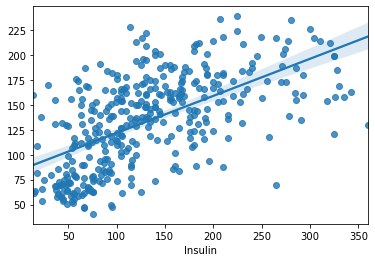

In [98]:
# regplot 으로 결과 값을 비교
sns.regplot(y_train, y_pred)

- regplot을 통해 회귀선이 구해짐. 회귀라는 것은 수치를 딱 맞추기 어려움
- 이상치 때문에 회귀선이 조금 더 기울어짐
- 200 미만의 값은 예측을 잘 했지만 200이상의 값들은 실제값과 예측값의 차이가 큼

In [99]:
# r2_score 를 구한다
from sklearn.metrics import r2_score

r2_score(y_train, y_pred)

0.3518742958004131

- 회귀가 잘 되었는지 측정하는 r2_score metric에서는 1에 가까워야 잘 예측한 것인데 회귀값과 예측값이 차이가 큰 경우가 있어서 수치가 낮게 나옴

F:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


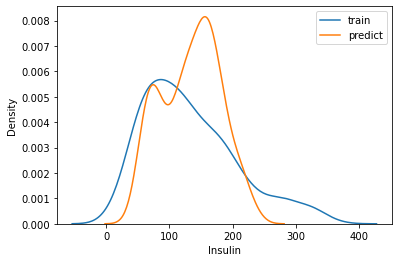

In [100]:
# distplot으로 정답값과 예측값의 분포를 그린다
sns.distplot(y_train, hist=False)
sns.distplot(y_pred, hist = False)
plt.legend(labels = ["train", "predict"])

# 오차 구하기

In [101]:
# MAE

error = abs(y_train - y_pred)
error.mean()

44.5550258134646

F:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Insulin', ylabel='Density'>

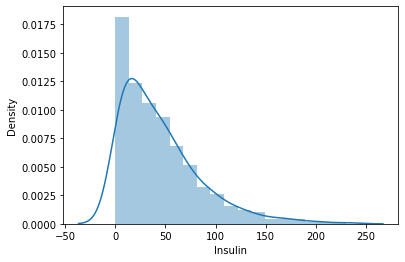

In [102]:
sns.distplot(error)

In [103]:
error.describe()

count    370.000000
mean      44.555026
std       39.825051
min        0.020760
25%       14.065870
50%       34.049413
75%       62.752250
max      230.014056
Name: Insulin, dtype: float64

In [104]:
# RMSE

np.sqrt(((y_train - y_pred ) ** 2).mean())

59.723516541856334

# 트리 알고리즘 분석하기
- 의사결정나무를 시각화
- 피처의 중요도를 구한다

In [105]:
# 피처의 중요도를 추출하기
best_estimator.feature_importances_

array([0.0546818 , 0.38515432, 0.06778327, 0.09533463, 0.13559257,
       0.10651047, 0.10790182, 0.04704111])

<AxesSubplot:>

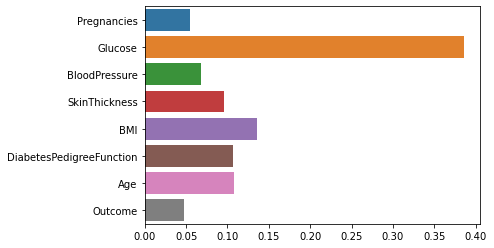

In [106]:
# 피처의 중요도 시각화하기
sns.barplot(x=best_estimator.feature_importances_, y=feature_names)

# 예측
- 실전 시험문제(X_test)라고 보면됨. 우리가 정답을 직접 예측.
- Insulin이 0인 값을 예측 했기 때문에 정답을 알 수 없음
- 따라서 점수는 train set으로 측정한 값을 참고

In [107]:
y_test = best_estimator.predict(X_test)
y_test[:5]

array([181.91683604,  61.675     , 180.09666667, 147.89328885,
       171.41      ])

In [108]:
train.groupby("Outcome")["Insulin"].agg(['mean', 'median'])

,mean,median
Outcome,,
0,115.917323,100
1,169.163793,160


In [109]:
train.groupby("Outcome")["Insulin"].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,254.0,115.917323,69.844697,15.0,64.25,100.0,151.00,342.0
1,116.0,169.163793,70.789454,14.0,124.25,160.0,207.75,360.0


In [110]:
test["Insulin"] = y_test
test.groupby("Outcome")["Insulin"].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,236.0,133.356169,43.039801,50.260491,96.621000,135.083156,166.946826,227.718000
1,138.0,172.379597,29.403884,99.275000,152.464264,172.639913,189.883177,244.917143


<AxesSubplot:xlabel='Outcome', ylabel='Insulin'>

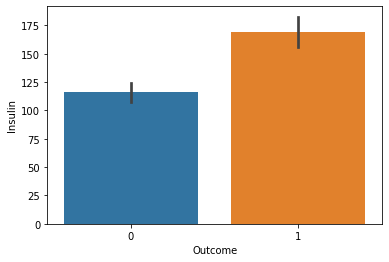

In [111]:
# Insulin의 평균값을 출력
sns.barplot(data = train, x = "Outcome", y = "Insulin")

<AxesSubplot:xlabel='Outcome', ylabel='Insulin'>

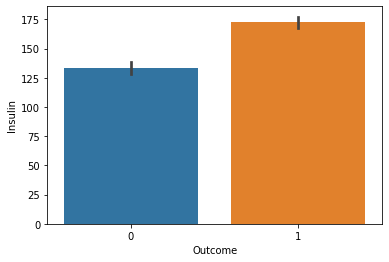

In [112]:
# 예측값으로 Insulin의 평균값을 출력
sns.barplot(data = test, x = "Outcome", y = "Insulin")

# 예측값을 CSV 파일로 저장하기

In [113]:
df.loc[df["Insulin"] == 0, "Insulin"]

0      0
1      0
2      0
5      0
7      0
      ..
761    0
762    0
764    0
766    0
767    0
Name: Insulin, Length: 374, dtype: int64

In [115]:
df.loc[df["Insulin"] == 0, "Insulin"] = test["Insulin"]

In [116]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,181.916836,33.6,0.627,50,1
1,1,85,66,29,61.675000,26.6,0.351,31,0
2,8,183,64,0,180.096667,23.3,0.672,32,1
3,1,89,66,23,94.000000,28.1,0.167,21,0
4,0,137,40,35,168.000000,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180.000000,32.9,0.171,63,0
764,2,122,70,27,171.439901,36.8,0.340,27,0
765,5,121,72,23,112.000000,26.2,0.245,30,0
766,1,126,60,0,157.509126,30.1,0.349,47,1


In [119]:
df.to_csv("data/diabetes_fill_insulin.csv", index = False)

In [120]:
pd.read_csv("data/diabetes_fill_insulin.csv")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,181.916836,33.6,0.627,50,1
1,1,85,66,29,61.675000,26.6,0.351,31,0
2,8,183,64,0,180.096667,23.3,0.672,32,1
3,1,89,66,23,94.000000,28.1,0.167,21,0
4,0,137,40,35,168.000000,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180.000000,32.9,0.171,63,0
764,2,122,70,27,171.439901,36.8,0.340,27,0
765,5,121,72,23,112.000000,26.2,0.245,30,0
766,1,126,60,0,157.509126,30.1,0.349,47,1
